In [1]:
import os
import time
import pickle

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from collections import defaultdict

import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as ly
from tensorflow.contrib.framework import nest 
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.framework import ops

sess_opt = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95 , allow_growth=True)
                         ,device_count={'GPU': 1})

from utils import exist_or_mkdir , data_manager , transform_orig

exp_folder = "YO_ver0"
model_path = "model_para"
tmp_path = "tmp"
log_path = "log"

In [2]:
exp_folder = exist_or_mkdir("./",exp_folder)
model_path = exist_or_mkdir(exp_folder,model_path)
tmp_path = exist_or_mkdir(exp_folder,tmp_path)
log_path = exist_or_mkdir(exp_folder,log_path)


Path : './YO_ver0'
Path : './YO_ver0/model_para'
Path : './YO_ver0/tmp'
Path : './YO_ver0/log'


In [3]:
Encoder_max_len = 40
Decoder_max_len = 30
min_count = 3
print_interval = 1500
train_batch_size = 200
n_epoch = 10

In [4]:
print("""
##################################################################################################
########################################  Loading Data  ##########################################
##################################################################################################
""")


##################################################################################################
########################################  Loading Data  ##########################################
##################################################################################################



In [5]:
train_path = ["data/{}/train.csv".format(x) for x in ["all"]]
test_path = ["data/{}/test.csv".format(x) for x in ["all"]]

print("### Loading Train Data ###")
data_agent = data_manager(train_path , train=True)


print("### Loading Test Data ###")
test_agent = data_manager(test_path , train=False)

### Loading Train Data ###
Data count : 651339

### Data view ###
Original data  : ['SOS', '唐达', 'EOS', 'nr', 'NOP', 'an', 'NOE', '1', 'NOR']
Output Sentence : ['SOS', '陶山', 'EOS']
### Loading Test Data ###
Data count : 70000

### Data view ###
Original data  : ['SOS', '总', '觉得', '自己', '在', '素刻', '程度', '上', '很', '吃力', 'EOS', 'v', 'n', 'uj', 'd', 'c', 'a', 'NOP', 'ao', 'NOE', '6', 'NOR']


In [6]:
print("\n### Preprocessing ###")
idx_in_sen , idx_out_sen , mask_in , mask_out , length_in , length_out , idx2word , word2idx , remain_idx =\
    transform_orig([data_agent.orig_data,data_agent.out_sen],min_count=min_count, max_len = [Encoder_max_len,Decoder_max_len])


### Preprocessing ###
Min Count : 3
Max Length : [40, 30]
Word Count : 59465
Orig data  : ['SOS', '哥', '呀', 'EOS', 'r', 't', 'v', 'f', 'm', 'v', 'NOP', 'iu', 'NOE', '6', 'NOR']
Index data : [3736, 681, 3, 12, 92, 15, 16, 14, 15, 18, 445, 20, 33, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Output Orig data  : ['SOS', '我', '前半晌', '绣', '后', '半晌', '绣', 'EOS']
Output Index data : [36, 44988, 13844, 546, 44989, 13844, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
pickle.dump({"orig_word":[idx2word,word2idx] },
            open(os.path.join(tmp_path,"tokenizer.pkl") , "wb"))

In [8]:
print("""
##################################################################################################
#######################################  Building Model  #########################################
##################################################################################################
""")
start_time = time.time()


##################################################################################################
#######################################  Building Model  #########################################
##################################################################################################



In [9]:
def encode(inputs,dim,dil,pad="same"):
    c0 = tf.layers.conv1d(inputs,dim,3,strides=1,dilation_rate=dil,activation=None,padding=pad)
    c0_score = tf.layers.conv1d(inputs,dim,3,strides=1,dilation_rate=dil,activation=tf.nn.sigmoid,padding=pad)
    return tf.multiply(c0,c0_score)

In [10]:
def deconv(inputs,encoder_vec,encoder_residual_vec,max_len,residual=None,dim=256,kernel_size=3,reuse_flag=True):
    print("Deconv inputs : " , inputs)
    with tf.name_scope("Deconv"):
        vec_o = encode(inputs,256,1)
        vec_o = encode(vec_o,256,1)
        vec_o = encode(vec_o,256,1,"valid")
        print(vec_o)
        vec = tf.concat([tf.tile(vec_o,[1,max_len,1]),encoder_vec],axis=-1)
        attn_score = tf.layers.dense(vec,dim//2,activation=tf.nn.leaky_relu)
        attn_score = tf.nn.softmax(tf.layers.dense(attn_score,1,activation=None),axis=1)
        out = tf.reduce_sum(encoder_residual_vec*attn_score,axis=1,keepdims=True)
        out = out + vec_o
    print("Deconv out :" , out)
    print("Deconv score :" , attn_score)
    return out , attn_score

In [11]:
def wordclf(inputs,dim,embd_T,reuse_flag=False,training=True):
    with tf.name_scope("WordClf"):
        print("Wordclf inputs : " ,inputs)
        fc1 = tf.layers.dense(inputs,dim,activation=None,name="fc1",reuse=reuse_flag)
    #     fc1 = tf.layers.batch_normalization(fc1,trainable=training,training=training,
    #                                         reuse=reuse_flag,name="BN1")
        fc1 = tf.nn.leaky_relu(fc1)
        fc2 = tf.layers.dense(fc1,embd_dim,activation=None,reuse=reuse_flag,name="fc2")
        print(fc2)
        flat = tf.layers.flatten(fc2)
        print(flat)
        out = flat @ embd_T
    return out

In [12]:
def dynamic_deconv(encoder,encoder_residual_vec,embd,embd_T,max_time):
    
    batch_size,max_len,encoder_dim = tf.unstack(tf.shape(encoder))
    
    emit_ta = nest.pack_sequence_as(int(embd.shape[0]),
                                    [tensor_array_ops.TensorArray(tf.float32,
                                                                  clear_after_read=False,
                                                                  size=0,
                                                                  dynamic_size=True,
                                                                  element_shape=tensor_shape.\
                                                                      TensorShape([None,len(idx2word)]))])
    emit_input = nest.pack_sequence_as(int(1),
                                           [tensor_array_ops.TensorArray(tf.int32,
                                                                         clear_after_read=False,
                                                                         size=0,
                                                                         dynamic_size=True,
                                                                         element_shape=tensor_shape.\
                                                                             TensorShape([None]))])
    
    emit_score = tensor_array_ops.TensorArray(tf.float32,
                                              clear_after_read=False,
                                              size=0,
                                              dynamic_size=True,
                                              element_shape=tensor_shape.\
                                                  TensorShape([None,None,1]))
    
    time = tf.constant(0,dtype=tf.int32)
    output_time = tf.constant(0,dtype=tf.int32)
    def initialize(batch_size,time,emit_input):
        for w in ["NULL" , "NULL" , "SOS"]:
            idx = tf.reshape(tf.constant(word2idx[w],dtype=tf.int32),[-1])
            idx = tf.tile(idx,[batch_size])
            emit_input = nest.map_structure(lambda ta,em: ta.write(time,em),emit_input,idx)
            time += 1
        return emit_input,time
    
    emit_input, time = initialize(batch_size,time,emit_input)
    
    def body(output_time,time,emit_input,emit_ta,emit_score):
        
        inputs_idx = tf.transpose(emit_input.gather([time-3,time-2,time-1]),[1,0])
        print("input idx",inputs_idx)
        
        inputs_vec = tf.nn.embedding_lookup(embd,inputs_idx)
        output_vec , attn_s= deconv(inputs_vec,encoder,encoder_residual_vec,max_len,dim=256,reuse_flag=False)
        output_logits = wordclf(output_vec,300,embd_T,reuse_flag=False)
        
        next_idx = tf.argmax(output_logits,axis=-1,output_type=tf.int32)
        emit_input = nest.map_structure(lambda ta,em:ta.write(time,em),emit_input,next_idx)
        time += 1
        
        emit_ta = emit_ta.write(output_time,output_logits)
        emit_score = emit_score.write(output_time,attn_s)
        output_time += 1
        
        return output_time,time,emit_input,emit_ta,emit_score
    
    def condition(t,*_):
        return t<max_time
    
    _,_,emit_input,emit_ta,emit_score = \
            tf.while_loop(condition,body,
                          loop_vars=[output_time,time,emit_input,emit_ta,emit_score],
                          swap_memory=False)
        
    emit_input = tf.transpose(emit_input.stack(),[1,0])[:,3::]
    emit_ta = tf.transpose(emit_ta.stack(),[1,0,2])
    emit_score = tf.transpose(emit_score.stack(),[1,0,2,3])
    emit_score = tf.reshape(emit_score , [batch_size,-1,max_len])
    return emit_input,emit_ta,emit_score

In [13]:
def get_grad_norm(_t_position,_p_position,pos_tensor):
    grad = tf.gradients(logits[0,_t_position,_p_position],pos_tensor)[0]
    return tf.sqrt(tf.reduce_sum(grad*grad,axis=-1))

In [14]:
embd_dim = 256
L0_dim = 256
L1_dim = 300
L2_dim = 300
clf_dim = 256

g_conv = tf.Graph()
with g_conv.as_default() as g:
    with tf.name_scope("Input"):
        _xs = tf.placeholder(tf.int32,[None,None])
        _xs_length = tf.placeholder(tf.int32,[None])
        xs_mask = tf.sequence_mask(_xs_length,dtype=tf.float32)
        
        _ys = tf.placeholder(tf.int32,[None,None])
        ys_one_hot = tf.one_hot(_ys,depth=len(idx2word))
        _ys_length = tf.placeholder(tf.int32,[None])
        ys_mask = tf.sequence_mask(_ys_length,dtype=tf.float32)
        
        t_place = tf.placeholder(tf.int32,[])
        _exp_idx = tf.placeholder(tf.int32,[None])
        
    with tf.name_scope("Embedding"):
        _embd = tf.get_variable("Embedding",[len(idx2word),embd_dim],dtype=tf.float32,trainable=True,
                                initializer=tf.truncated_normal_initializer(stddev=0.1))
        _embd_T = tf.transpose(_embd,[1,0])
        x_vector = tf.nn.embedding_lookup(_embd, _xs, max_norm=10)
        
        _exp_vec = tf.nn.embedding_lookup(_embd,_exp_idx)
        
    with tf.name_scope("Conv_encode"):
        en_conv1 = encode(x_vector,L0_dim,1)
        en_conv2 = encode(en_conv1,L0_dim,2)
        en_conv3 = encode(en_conv2,L0_dim,4)
        
    with tf.name_scope("Conv_decode"):
        _pred , logits , _attn_map = dynamic_deconv(en_conv3,x_vector+en_conv3,_embd,_embd_T,t_place)
    
    with tf.name_scope("Loss"):
        ce = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ys_one_hot,logits=logits)*ys_mask
        ce = tf.reduce_sum(ce,axis=1,keepdims=False)/tf.cast(_ys_length,tf.float32)
        _loss = tf.reduce_mean(ce)
        
    with tf.name_scope("Train"):
        opt = tf.train.AdamOptimizer(5e-4)
        _update = opt.minimize(_loss)
        
    with tf.name_scope("Gradient"):
        _t_position = tf.placeholder(tf.int32)
        _p_position = _pred[0,_t_position]
        xs_vector_gradnorm = get_grad_norm(_t_position,_p_position,x_vector)
        conv1_gradnorm = get_grad_norm(_t_position,_p_position,en_conv1)
        conv2_gradnorm = get_grad_norm(_t_position,_p_position,en_conv2)
    
    all_var = tf.trainable_variables()
    _init = tf.global_variables_initializer()
    saver = tf.train.Saver(max_to_keep=8,var_list=tf.trainable_variables())
#     tf.summary.FileWriter(log_path,graph=g)

input idx Tensor("Conv_decode/while/transpose:0", shape=(?, 3), dtype=int32)
Deconv inputs :  Tensor("Conv_decode/while/embedding_lookup:0", shape=(?, 3, 256), dtype=float32)
Tensor("Conv_decode/while/Deconv/Mul_2:0", shape=(?, 1, 256), dtype=float32)
Deconv out : Tensor("Conv_decode/while/Deconv/add:0", shape=(?, 1, 256), dtype=float32)
Deconv score : Tensor("Conv_decode/while/Deconv/transpose_1:0", shape=(?, ?, 1), dtype=float32)
Wordclf inputs :  Tensor("Conv_decode/while/Deconv/add:0", shape=(?, 1, 256), dtype=float32)
Tensor("Conv_decode/while/WordClf/fc2/BiasAdd:0", shape=(?, 1, 256), dtype=float32)
Tensor("Conv_decode/while/WordClf/flatten/Reshape:0", shape=(?, 256), dtype=float32)


In [15]:
print("Consume time : {:.2f}".format(time.time()-start_time))
print()

Consume time : 2.72



In [16]:
def calculate_var(var):
    d = 0
    for w in var:
        tmp_d = 1
        for ww in w.shape:
            tmp_d *= int(ww)
        d += tmp_d
    print("Var Count :" , d)
    return d

calculate_var(all_var)

Var Count : 17805357


17805357

In [17]:
print("""
##################################################################################################
#######################################  Start Infering  #########################################
##################################################################################################\n
""")


##################################################################################################
#######################################  Start Infering  #########################################
##################################################################################################




In [18]:
sess = tf.Session(graph=g_conv,config=sess_opt)
sess.run(_init)

In [26]:
def get_batch(i):
    tmp_end = max(length_in[i])
    out_max_len = max(length_out[i])
    my_dict = {
        _xs:idx_in_sen[i,:tmp_end],
        _ys:idx_out_sen[i,:out_max_len],
        _ys_length:length_out[i],
        t_place:out_max_len
    }
    return my_dict


# In[20]:


def evaluate_batch(sess,_pred,count=3):
    idx = np.random.choice(idx_in_sen.shape[0],[count])
    tmp_max_len = max(length_in[idx])
    my_dict = {
        _xs:idx_in_sen[idx,:tmp_max_len],
        t_place:30
    }
    start_t = time.time()
    pred = sess.run(_pred , feed_dict=my_dict)
    print(time.time()-start_t)
    word_seq = []
    for i in range(3):
        idx_sen = pred[i]
        tmp = []
        for t in range(Decoder_max_len-1):
            if(idx_sen[t] == 3):
                break
            tmp.append(idx2word[idx_sen[t]])
        word_seq.append(tmp)
    
    print("Max length :" , tmp_max_len)
    for i in range(3):
        print("  Input word  :" , data_agent.orig_data[remain_idx[idx[i]]])
        print("  Input index :" , idx_in_sen[idx[i],:tmp_max_len])
        print("  Ground word :" , data_agent.out_sen[remain_idx[idx[i]]])
        print("    Output    :" , word_seq[i])
        print()


In [20]:
batch_size = train_batch_size
n_step = idx_in_sen.shape[0]//batch_size

r_index = np.arange(idx_in_sen.shape[0])
loss_list = []
time_list = []
try:
    for e in range(1,10+1):
        np.random.shuffle(r_index)
        
        start = 0
        for s in range(n_step):
            idx = r_index[start:start+batch_size]
            batch = get_batch(idx)
            start_time = time.time()
            _ = sess.run(_update , feed_dict=batch)
            time_list.append(time.time()-start_time)
            l = sess.run(_loss,feed_dict=batch)
            start += batch_size
            print("step {:>5d} loss : {:>9.4f} time : {:>7.2f}".format(s,l,time_list[-1]) , end="\r")
            loss_list.append(l)
            if s % print_interval == 0:
                print("step {:>5d} loss : {:>9.4f} time : {:>7.2f}".format(s,l,np.mean(time_list)) , end="\n")
                evaluate_batch(sess,_pred,3)
        print("\nEpoch {0:>3d}/{1:d} loss : {2:>9.4f} time : {3:>8.2f}".format(e,n_epoch,l,time.time()-start_time))

        evaluate_batch(sess,_pred,3)

        if e%4 == 0:
            saver.save(sess,os.path.join(model_path,"model_{}.ckpt".format(e)))
except KeyboardInterrupt :
    print("Interrupt .. Save lastest model...")
    saver.save(sess,os.path.join(model_path,"model_{}.ckpt".format("lastest")))
    print()
    
print("Save loss history...")
pickle.dump(loss_list,open(os.path.join(log_path,"loss.pkl") , "wb"))


# In[ ]:


print("\n### Training Finished!! ###\n")

step     0 loss :   10.9497 time :    2.52
Max length : 23
  Input word  : ['SOS', '水', '不', '转', '哪', '山', '也', '转', 'EOS', 'v', 'a', 'uj', 'n', 'NOP', 'iu', 'NOE', '4', 'NOR']
  Input index : [2168  270  394 1056 3421   68  394    3   15   40   41   31   18  445
   20   73   22    0    0    0    0    0    0]
  Ground word : ['SOS', '没有', '憋死', '的', '牛', 'EOS']
    Output    : ['鸥鸟', '老祖', '鸥鸟', '风动', '鸥鸟', '鸥鸟', '鸥鸟', '通行', '通行', '开著', '鸥鸟', '算了吧', '鸥鸟', '鸥鸟', '鸥鸟', '通行', '通行', '开著', '鸥鸟', '算了吧', '鸥鸟', '鸥鸟', '鸥鸟', '通行', '通行', '开著', '鸥鸟', '算了吧', '鸥鸟']

  Input word  : ['SOS', '小右', '把', '快乐', '气氛', '传递', '到', '每个', '角落', 'EOS', 'v', 'n', 'k', 'uj', 'n', 'd', 'p', 'n', 'v', 'NOP', 'uo', 'NOE', '9', 'NOR']
  Input index : [    1   566   188   370 11675   387  2578  3334     3    15    31  2212
    41    31    17    13    31    15    18   461    20    21    22]
  Ground word : ['SOS', '希望', '孩子', '们', '的', '红包', '不再', '被', '家长', '缴获', 'EOS']
    Output    : ['第二', '撇下', '谁入', '偏方', '黑眼',

In [21]:
np.mean(time_list)

0.3495474839392509

In [27]:
evaluate_batch(sess,_pred,1000)

1.3950645923614502
Max length : 40
  Input word  : ['SOS', '她', '听着', '着', '了', '迷', '想', '去', '那个', '地方', 'EOS', 'r', 'v', 'm', 'an', 'uj', 'n', 'NOP', 'e', 'NOE', '6', 'NOR']
  Input index : [ 914 6773   44   52 1488  119  202 1544 1670    3   12   15   14  136
   41   31   18   78   20   33   22    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
  Ground word : ['SOS', '这', '是', '一个', '危险', '的', '时刻', 'EOS']
    Output    : ['我', '是', '一个', '温暖', '的', '歌']

  Input word  : ['SOS', '陪', '你', '永世', '不', '老', '千年', '眷顾', '一', '笑', 'EOS', 'x', 'q', 'n', 'uj', 'nr', 'NOP', 'ian', 'NOE', '5', 'NOR']
  Input index : [  402     5  8541   270  1685  4339 21099  1477   314     3   500    56
    31    41    39    18   124    20    79    22     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
  Ground word : ['SOS', '娜', '样', '纯杰', '的', '爱恋', 'EOS']
    Output    : ['啷', '个', 'OOV

### Visualization

In [23]:
import pickle

from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib import pyplot as plt
saver.restore(sess,os.path.join(model_path,"model_10.ckpt"))

INFO:tensorflow:Restoring parameters from ./Conv1D_ver0/model_para/model_10.ckpt


#### Attention map

In [26]:
word2idx["舔着"]

28617

In [52]:
def get_special_sen():
    f = open("expcode.txt","r")
    x = f.readline().strip().split(" ")
    print(x)
    f.close()
    idx_arr = []
    for s in x:
        try:
            idx_arr.append(word2idx[s])
        except:
            idx_arr.append(word2idx["OOV"])
    print(idx_arr)
    return [idx_arr]

def get_attn_special_sen(flag=False,arr = None , gt_arr=None):
    if flag:
        exp_arr = []
        for wi in arr:
            try:
                exp_arr.append(word2idx[idx2word[wi]])
            except:
                exp_arr.append(word2idx["OOV"])
            if(idx2word[wi] == "NOR"):
                break
        print(" ".join([idx2word[wi] for wi in exp_arr]))
        print(exp_arr)
        print("GT :" , " ".join([idx2word[wi] for wi in gt_arr]))
        exp_arr = [exp_arr]
        pass
    else:
        exp_arr = get_special_sen()
    attn,out = sess.run([_attn_map,_pred],feed_dict={_xs:exp_arr,t_place:20})
    tmp = []
    for i in out[0]:
        tmp.append(idx2word[i])
        if(tmp[-1] == "EOS"):
            break
    print(" ".join(tmp))
    return attn

idx = np.random.choice(len(idx_in_sen))
attn_map = get_attn_special_sen(True,idx_in_sen[idx],idx_out_sen[idx])

胜利 的 时候 当 我们 并肩 我 不会 忘记 那天 阳光 的 灿烂 EOS v uj n r p v v a NOP an NOE 8 NOR
[6811, 10, 888, 339, 200, 16951, 36, 102, 357, 651, 839, 10, 940, 3, 15, 41, 31, 12, 13, 15, 15, 40, 18, 136, 20, 42, 22]
GT : 想哭 的 时候 我们 用 仰望 止住 遗憾 EOS NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
离开 的 结局 我 从 没有 止住 遗憾 EOS


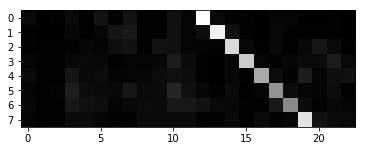

In [56]:
plt.imshow(attn_map[0][0:8],cmap="gray")
plt.yticks([i for i in range(8)],[i for i in range(8)])
plt.show()


In [21]:
idx = np.random.choice(len(idx_in_sen))
print(idx)
my_dict = get_batch([idx])
# my_dict[t_place] += 2
aa_map,aa_pred = sess.run([_attn_map , _pred],my_dict)

for i,w in enumerate(idx_in_sen[idx]):
    print(idx2word[w],", ",end="")

603891
他 , 说 , 你 , 还 , 没 , 长大 , 所以 , 你 , 要 , 乖乖 , 听话 , EOS , d , uj , r , p , v , m , n , c , v , NOP , ang , NOE , 9 , NOR , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , 

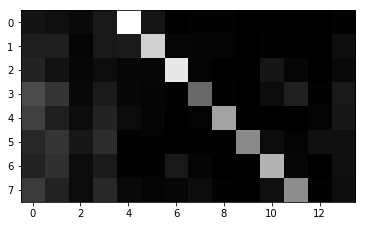

是 , 你 , 的 , 诺言 , 爱 , 我 , 永远 , EOS , 
是 , 我 , 的 , 诺言 , 爱 , 她 , 永远 , EOS , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , 

In [270]:
plt.imshow(aa_map[0],cmap="gray")
plt.show()

for i,w in enumerate(aa_pred[0]):
#     print(i,": {0:<10s} {1: <10s}".format(w ,idx2word[aa_pred[0][i]]))
    print(idx2word[w] , ", ", end="")
print()
for i,w in enumerate(idx_out_sen[idx]):
    print(idx2word[w] , ", ", end="")

#### Grad map

In [57]:
idx = np.random.choice(len(idx_in_sen))
print(idx)
print()

my_dict = get_batch([idx])
# my_dict[t_place] += 2
print("Input : " , end="")
for i,w in enumerate(idx_in_sen[idx]):
    print(idx2word[w],", ",end="")
print("\n")
print("Ground: " , end="")
for i,w in enumerate(idx_out_sen[idx]):
    print(idx2word[w],", ",end="")
print()
print("output length :",my_dict[t_place])

507340

Input : 快快 , 拿到 , 学校 , 炫耀 , 吧 , 孩子 , 交点 , 朋友 , 吧 , EOS , y , r , v , r , s , v , uj , v , r , zg , NOP , a , NOE , 10 , NOR , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , 

Output : 哎呀呀 , 你 , 看 , 你 , 手上 , 拿 , 的 , 是 , 什么 , 啊 , EOS , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , NULL , 
output length : 11


Position output : EOS
哎呀呀 你 看 你 心里 拿 的 是 什么 啊 EOS 


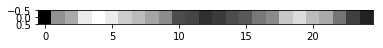

In [61]:
end = 10
my_dict[_t_position] = end
gn , my_pred = sess.run([xs_vector_gradnorm,_pred],my_dict)
print("Position output :" , idx2word[my_pred[0,my_dict[_t_position]]])
for i,w in enumerate(my_pred[0]):
    print(idx2word[w] ,"" , end="")
print()

gn -= gn.min()
gn /= gn.max()
plt.imshow(gn,cmap="gray")
plt.show()

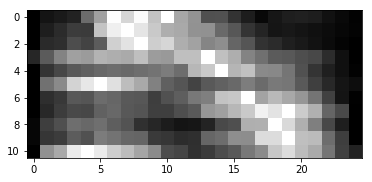

In [59]:
my_dict[_t_position] = 0
gn , my_pred = sess.run([xs_vector_gradnorm,_pred],my_dict)
gn -= gn.min()
gn /= gn.max()
for i in range(1,end+1):
    my_dict[_t_position] = i
    tmp = sess.run(xs_vector_gradnorm,my_dict)
    tmp -= tmp.min()
    tmp /= tmp.max()
    gn = np.concatenate([gn,tmp],axis=0)

plt.imshow(gn,cmap="gray")
plt.show()

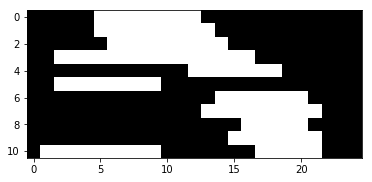

In [60]:
plt.imshow(gn>0.5,cmap="gray")
plt.show()

Position output : 那年
我们 , 难忘 , 的 , 那年 , EOS , 


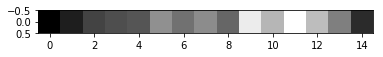

In [332]:
gn , my_pred = sess.run([conv1_gradnorm,_pred],my_dict)
print("Position output :" , idx2word[my_pred[0,my_dict[_t_position]]])
for i,w in enumerate(my_pred[0]):
    print(idx2word[w] , ", " , end="")
print()

gn -= gn.min()
gn /= gn.max()
plt.imshow(gn,cmap="gray")
plt.show()

Position output : 那年
我们 , 难忘 , 的 , 那年 , EOS , 


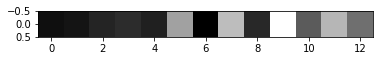

In [333]:
gn , my_pred = sess.run([conv2_gradnorm,_pred],my_dict)
print("Position output :" , idx2word[my_pred[0,my_dict[_t_position]]])
for i,w in enumerate(my_pred[0]):
    print(idx2word[w] , ", " , end="")
print()

gn -= gn.min()
gn /= gn.max()
plt.imshow(gn,cmap="gray")
plt.show()

#### Activation map

In [215]:
act_map = sess.run(conv2,my_dict)

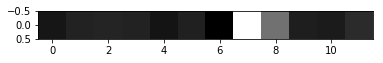

In [347]:
i = 50
plt.imshow(act_map.reshape(12,256)[:,i:i+1].T,cmap="gray")

#### Change rhyme

In [373]:
rhy_token = pickle.load(open("Tok.pkl" , "rb"))["rhy"]
len_token = pickle.load(open("Tok.pkl" , "rb"))["len"]
pos_token = pickle.load(open("Tok.pkl" , "rb"))["pos"]

In [359]:
def pad_zero(data , r , max_len):
    arr = []
    for sample in data:
        arr.append([x for x in sample])
        arr[-1].extend([0 for _ in range(max_len-len(arr[-1]))])
    
    return arr

In [370]:
def exp_change_rhyme(r,sample_num = 5000,f=None):
    
    from pypinyin import Style, lazy_pinyin
    def check_tone(ss):
        tone = lazy_pinyin(ss[-1], style=Style.FINALS, strict=False)[0]
        if(tone == r):
            return 1
        else:
            return 0
        
    sample = np.random.choice(len(data_agent.orig_data),sample_num,replace=False)
    
    arr = []
    max_len = 0
    orig_rhy = []
    for i in sample:
        ss = data_agent.orig_data[i][1::]
        if(len(ss) > max_len):
            max_len = len(ss)
        flag = False
        tmp = []
        for s in ss:
            if(flag):
                orig_rhy.append(s)
                tmp.append(word2idx[r])
                flag=False
                continue
            try:
                tmp.append(word2idx[s])
            except KeyError:
                tmp.append(word2idx["OOV"])
            if(s == "NOP"):
                flag = True
        arr.append(tmp)
    
            
    output_seq = []
    for i in range(sample_num//1000):
        
        batch_data = arr[i*1000:i*1000+1000]
        batch_data = pad_zero(batch_data,0,max_len)
        decode = sess.run(_pred,feed_dict={_xs:batch_data,t_place:30})
        for d in decode:
            rhy_word = r
            for si in d:
                if(si == word2idx["EOS"]):
                    break
                rhy_word = idx2word[si]
            output_seq.append( check_tone(rhy_word) )
    if(f):
        print("Change rhy to",r,file=f)
        print("Accuracy :" , sum(output_seq)/sample_num,file=f)
    else:
        print("Change rhy to",r)
        print("Accuracy :" , sum(output_seq)/sample_num)
    assert len(output_seq) == len(orig_rhy)
    ## confusion matrix
    vector = np.zeros([len(rhy_token)])
    vector_count = np.zeros([len(rhy_token)])
    for i,t_r in enumerate(rhy_token):
        for j,o_r in enumerate(orig_rhy):
            if(o_r == t_r):
                if(output_seq[j] == 1):
                    vector[i]+=1
                vector_count[i]+=1
    return vector/vector_count

In [ ]:
ff = open("Confusion_m.log","w")
confuse_m = []
for r in rhy_token[::-1]:
    v = exp_change_rhyme(r,70000,ff)
    confuse_m.append(v)
ff.close()

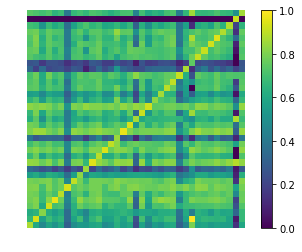

In [369]:
con_confuse = np.stack(confuse_m,axis=0)

plt.imshow(con_confuse)
plt.colorbar()
plt.axis("off")
plt.show()

#### Embedding

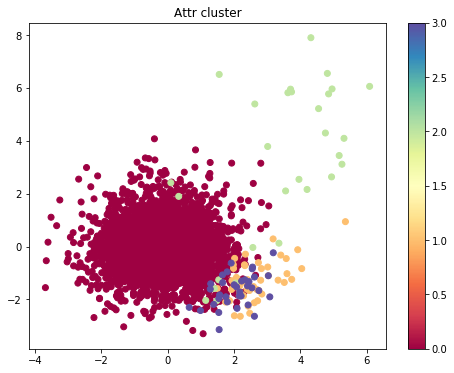

In [383]:
def get_lda_embed_transform_vec():
    posTok_idx = [word2idx[i] for i in pos_token]
    lenTok_idx = [word2idx[i] for i in len_token]
    rhyTok_idx = [word2idx[i] for i in rhy_token]
    wordTok_idx = np.random.choice([word2idx[w] for w in idx2word if not ( w in pos_token or w in len_token or w in rhy_token )], 
                                   3000, replace=False)

    label_dict = ["word" , "pos" , "len" , "rhy" ]

    v_pos = sess.run(_exp_vec,feed_dict={_exp_idx:posTok_idx})
    v_len = sess.run(_exp_vec,feed_dict={_exp_idx:lenTok_idx})
    v_rhy = sess.run(_exp_vec,feed_dict={_exp_idx:rhyTok_idx})
    v_word = sess.run(_exp_vec,feed_dict={_exp_idx:wordTok_idx})

    lda = LDA(n_components=3)
    attr_label = np.concatenate([np.ones([v.shape[0]])*i for i,v in enumerate([v_word , v_pos , v_len , v_rhy ])],axis=0)
    concat_vec = np.concatenate([v_word , v_pos , v_len , v_rhy ],axis=0)

    attr_transform_vec = lda.fit_transform(concat_vec,attr_label)
    
    return attr_transform_vec , attr_label

def plot_embd(transform_vec,label,title,save=None):
    plt.figure(figsize=[8,6])
    plt.title(title)
    plt.scatter(transform_vec[:,0],transform_vec[:,1],c=label,cmap="Spectral")
    plt.colorbar()
    if save:
        plt.savefig(save)
    plt.show()

    
attr_transform_vec , attr_label = get_lda_embed_transform_vec()
plot_embd(attr_transform_vec,attr_label,"Attr cluster",save="attr_lda_embedd.png")